# Load file

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from tqdm import tqdm
dir = '/content/gdrive/MyDrive/archive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


article

In [19]:
nRowsRead = None # specify 'None' if want to read whole file
# nyt-articles-2020.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/gdrive/MyDrive/archive/nyt-articles-2020.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'nyt-articles-2020.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 16787 rows and 11 columns


comment

In [20]:
nRowsRead = None # specify 'None' if want to read whole file
# nyt-comments-2020.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv( dir+'/nyt-comments-2020.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'nyt-comments-2020.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')
article = np.array(df1)
comments = np.array(df2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


There are 4986461 rows and 23 columns


# Data cleaning

Article cleaning \\
列数从0开始 \\
第1列 第2列不出现 politics \\
第6列不出现 [] \\
第7列筛选文章词数大于50 \\
第9列筛选comments个数大于50 \\




In [21]:
#只保留sports和movies
# df1_1 = df1.drop(df1[df1['section'] != 'Sports'].index)
# df1_2 = df1.drop(df1[df1['section'] != 'Movies'].index)
# cleaned_arti = pd.concat([df1_1, df1_2])
cleaned_arti = df1
#第六列不出现空
cleaned_arti = cleaned_arti.drop(cleaned_arti[cleaned_arti['keywords'] == '[]'].index)
#第七列筛选次数大于50
cleaned_arti = cleaned_arti.drop(cleaned_arti[cleaned_arti['word_count'] < 50].index)
#第九列comments个数大于50
cleaned_arti = cleaned_arti.drop(cleaned_arti[cleaned_arti['n_comments'] < 50].index)
#取出对应的article id
#article只保留四列
cleaned_arti = cleaned_arti[['headline','abstract','keywords', 'uniqueID']]

In [22]:
cleaned_arti.dropna(axis=0,how='any')

,headline,abstract,keywords,uniqueID
0,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
5,Pro-Iranian Protesters End Siege of U.S. Embas...,Iran’s ability to deploy militias to attack th...,"['Iraq', 'Iran', 'United States', 'Demonstrati...",nyt://article/ac742403-9ccd-522f-9a1e-a90feb6c...
7,"She Felt Fine, but Her M.R.I. Showed Several S...",After the 67-year-old woman fell at the airpor...,"['Stroke', 'Brain', 'Heart', 'Medicine and Hea...",nyt://article/dfd5bb59-f330-5c01-ae02-221e6f9c...
10,"Eat Better, Feel Better? Food Advice From the ...","Intermittent fasting, drinking less alcohol an...","['Weight', 'Fasting', 'Diet and Nutrition']",nyt://article/da74e3b3-f027-5b03-9052-0bc2e69a...
...,...,...,...,...
16781,Here’s Why Distribution of the Vaccine Is Taki...,Health officials and hospitals are struggling ...,"['Vaccination and Immunization', 'Coronavirus ...",nyt://article/5320a2e9-d739-542a-a397-443c4323...
16782,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...
16784,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...
16785,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia...",nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...


In [23]:
kw_set = np.array(cleaned_arti['keywords'])

In [24]:
keep_idx = []
for i, kw in enumerate(kw_set):
    if str(kw)=='nan' or ',' not in kw or len(kw.split(',')) < 10:
        pass
    else:
        keep_idx.append(i)

In [25]:
cleaned_arti = cleaned_arti.iloc[keep_idx, :]

In [26]:
len(cleaned_arti)

4084

Comments cleaning \\
根据cleaned article筛选comments \\


In [27]:
uni_id = cleaned_arti['uniqueID'].to_numpy()
cleaned_comm = df2[df2['articleID'].isin(uni_id)]
cleaned_comm = cleaned_comm[['commentBody','articleID']]

In [28]:
comment_len_list = []
a = np.array(cleaned_comm['commentBody'])
for comm in tqdm(a):
    comment_len_list.append(len(comm.split(' ')))
comment_len_list = np.array(comment_len_list)

100%|██████████| 2375148/2375148 [00:10<00:00, 233712.44it/s]


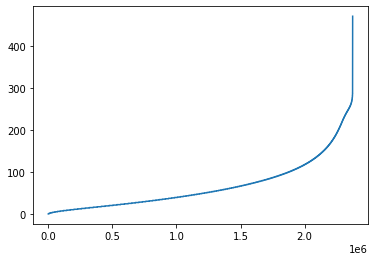

In [29]:
plt.plot(np.sort(comment_len_list))

In [30]:
np.mean(comment_len_list)

66.62632518057822

reconstruct keywords

In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 


# new version
def extract_kw(cleaned_arti):
    # stop words in English
    stop = set(stopwords.words('english')) 
    #extract keywords from cleaned article
    kw_set = np.array(cleaned_arti['keywords'])
    new_kw_set = []
    for i, kw in enumerate(kw_set):
        kw = kw.split(',') if ',' in kw else kw
        for j in range(len(kw)):
            kw[j] = re.sub(u"([^\u0041-\u005a\u0061-\u007a\u0020])", "", kw[j])
            kw[j] = kw[j].strip()
        kw = np.array([i for i in kw if i != "" and i not in stop])
        kw_set[i] = np.unique(kw)
        new_kw_set.append(np.unique(kw))
    new_kw_set = np.concatenate(new_kw_set[:])
    return new_kw_set, kw_set


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
kw_list, kw = extract_kw(cleaned_arti)

#Train new tokenizer

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizerFast
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

# all_tokens = list(np.concatenate((np.array(cleaned_arti['headline']), kw_list, np.array(cleaned_comm['commentBody']), np.array(cleaned_arti['abstract']))))

# batch_size = 1000
# all_texts = [all_tokens[i : i + batch_size] for i in range(0, len(all_tokens), batch_size)]

# def batch_iterator(dataset):
#     for i in range(0, len(dataset), batch_size):
#         yield dataset[i : i + batch_size]

# tokenizer = tokenizer.train_new_from_iterator(all_texts, vocab_size=60000)
# save_directory_tokenizer = '/content/gdrive/MyDrive/withoutBERT_tokenizer'
# tokenizer.save_pretrained(save_directory_tokenizer)

In [52]:
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer
all_tokens = list(np.concatenate((np.array(cleaned_arti['headline']), kw_list, np.array(cleaned_comm['commentBody']), np.array(cleaned_arti['abstract']))))
batch_size = 1000
all_texts = [all_tokens[i : i + batch_size] for i in range(0, len(all_tokens), batch_size)]

tokenizer = Tokenizer(models.WordPiece(unl_token="[UNK]"))
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=60000, special_tokens=special_tokens)
tokenizer.train_from_iterator(all_texts, trainer=trainer)

In [53]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", cls_token_id),
        ("[SEP]", sep_token_id),
    ],
)
tokenizer.decoder = decoders.WordPiece(prefix="##")
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)
save_directory_tokenizer = '/content/gdrive/MyDrive/withoutBERT_tokenizer'
tokenizer.save_pretrained(save_directory_tokenizer)

('/content/gdrive/MyDrive/withoutBERT_tokenizer/tokenizer_config.json',
 '/content/gdrive/MyDrive/withoutBERT_tokenizer/special_tokens_map.json',
 '/content/gdrive/MyDrive/withoutBERT_tokenizer/vocab.txt',
 '/content/gdrive/MyDrive/withoutBERT_tokenizer/added_tokens.json',
 '/content/gdrive/MyDrive/withoutBERT_tokenizer/tokenizer.json')

# Node extraction

In [56]:
# 略加修改

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class DataSeq(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        return sequence
    
    def __len__(self):
        return len(self.sequences)

import string 

def not_break(sen):
    return (sen != '\n' and sen != '\u3000' and  sen != '' and not sen.isspace())
def filter_data(ini_data):
    new_data = list(filter(not_break, [data.strip() for data in ini_data]))
    return new_data

import gc
for i in range(len(kw)):
    kw[i] = kw[i].astype('<U5000')

headline = np.array(cleaned_arti['headline'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def recon_kw(kw, headline, cleaned_arti, cleaned_comm):
    data_list = []
    sample_num = 10
    sample_comment_set = []
    sample_comment_set_atten_mask = []
    edge_connection_box, edge_feat_box = [], []

    #divider
    english_punctuation = string.punctuation
    eng_punc = '|'.join([c for c in english_punctuation])
    eng_punc  = eng_punc[:-5] + eng_punc[-3:]

    uni_id = np.array(cleaned_arti['uniqueID'])

    #construct abstract set
    abstract_set = np.array(cleaned_arti['abstract'])

    #iterate through each article
    for i, id in enumerate(tqdm(uni_id)):
        #find corresponding comments set
        idx = np.where(np.array(cleaned_comm['articleID']) == id)
        comment_set = np.array(cleaned_comm['commentBody'])[idx]

        #constract abstract in sentence for one id
        abstract = abstract_set[i]
        abstract_kw = filter_data(re.split(r''+("["+eng_punc+"]"), abstract))
        abstract_kw = [abstract.strip('\n') for abstract in abstract_kw]
        
        #iterate through each comment, construct comment set
        comm_list = []
        comm_kw = []
        for comm in comment_set:
            comm_k = re.sub(u"([^\u0061-\u007a\u0030-\u0039\u0020\u0041-\u005a])", "", comm.strip('\n'))
            comm1 = comm_k.split(' ')
            comm_list.extend(comm1)
            comm_k = comm.strip('\n')
            comm_kw.append(comm_k)
        
        #construct dict
        comm_dict = {}
        for comm in comm_list:
            if comm in comm_dict:
                comm_dict[comm] += 1
            else:
                comm_dict[comm] = 1
        
        # take out the top10
        top = 10
        freq_threshold = 10
        stop_words = 50

        # rank comm_dict
        comm_dict = np.array(sorted(comm_dict.items(), key=lambda item:item[1], reverse=True))[stop_words:]
        comm_kw_list = np.array(comm_dict[:, 0])
        freq_list = np.array(np.array(comm_dict[:, 1], dtype=np.int64))

        # append keywords
        #************************************************************************************
        # delete stop words
        idx = np.where(freq_list >= freq_threshold)[0]
        kw[i] = np.concatenate((kw[i], comm_kw_list[idx])) if len(idx) <= top else np.concatenate((kw[i], comm_kw_list[:top]))
        kw[i] = np.unique(kw[i])

        # append headline at the end of each graph
        headline[i] = headline[i].strip('\n')
        headline[i] =  np.delete(headline[i], np.where(headline[i] == ''))
        kw[i] = np.concatenate((kw[i], headline[i]))




        # copy kw, without the first empty node
        kw_copy = kw[i].copy()


        #sample several comments as target
        random_idx = np.arange(len(comm_kw))
        np.random.shuffle(random_idx)
        sample_idx = random_idx[:sample_num]
        sample_max_length = 50
        sample_comment = np.zeros((sample_num, sample_max_length))
        sample_comment_mask = np.zeros((sample_num, sample_max_length))
        for idx in range(len(sample_idx)):
            selected_comm = comm_kw[idx]
            sample_encoding = tokenizer.encode_plus(selected_comm, padding='max_length', add_special_tokens=True, max_length=sample_max_length, truncation=True, return_attention_mask=True)
            sample_comment[idx] = sample_encoding['input_ids']
            sample_comment_mask[idx] = sample_encoding['attention_mask']
            del comm_kw[idx]
            gc.collect()
        sample_comment_set.append(sample_comment)
        sample_comment_set_atten_mask.append(sample_comment_mask)

        # add comment and abstract to node
        comm_kw.extend(abstract_kw)
        docs = comm_kw

        counter = np.zeros(len(docs))
        counter_edge = np.zeros((len(kw_copy[:-1]), len(docs)))
        
        # add corresponding sentences to keywords
        #************************************************************************************
        for j, single_kw in enumerate(kw_copy[:-1]):
            # convert to word
            single_kw_set = re.sub(u"([^\u0061-\u007a\u0020])", "", single_kw.strip('\n').lower()).split(' ')
            for k, doc in enumerate(docs):  
                doc_copy = re.sub(u"([^\u0061-\u007a\u0020])", "", doc.strip('\n').lower())
                exist = 0
                for s_kw in single_kw_set:
                    if s_kw in doc_copy.split(' ') and exist == 0:
                        exist = 1
                        kw[i][j] += ' '
                        kw[i][j] = np.char.add(kw[i][j], doc)
                        counter[k] += 1
                        counter_edge[j, k] += 1
                    else:
                        pass
        #************************************************************************************



        # construct empty node 
        empty_node = np.array([''], dtype='<U10000')
        kw[i] = np.concatenate((empty_node, kw[i]))
        
        # add doc to empty node
        if len(np.where(counter == 0)[0]) != 0:
            empty_doc = np.array(docs)[np.where(counter == 0)[0]]
            kw[i][0] = np.char.add(kw[i][0], ' '.join(empty_doc))

        #encode and generate graph.x data file
        path = '/content/gdrive/MyDrive/withoutBERT_graph'
        if not os.path.exists(path):
            os.makedirs(path)

        path_mask = '/content/gdrive/MyDrive/withoutBERT_mask'
        if not os.path.exists(path_mask):
            os.makedirs(path_mask)

        # for ith, row in enumerate(kw[i]):
        #     input = tokenizer.encode_plus(row, padding='max_length',add_special_tokens=True, max_length=200, truncation=True, return_attention_mask=True, return_tensors = "pt").to(device)
        #     torch.save(model(**input)[0][0][1], path + "/node{0:}.pt".format(ith))

        text_list = [row for row in kw[i]]
        dataset_i = DataSeq(text_list)
        data_loader = DataLoader(dataset_i, batch_size=32, shuffle=False, num_workers=0)
        embedding_repre = []
        embedding_mask = []
        with torch.no_grad():
            for sequence in data_loader:           
                input = tokenizer.batch_encode_plus(sequence, padding='max_length', add_special_tokens=True, max_length=100, return_attention_mask=True, truncation=True, return_tensors = "pt").to(device)         
                embedding_repre.append(input['input_ids'].cpu().numpy())
                embedding_mask.append(input['attention_mask'].cpu().numpy())
        embedding_repre = np.concatenate(embedding_repre[:])
        embedding_mask = np.concatenate(embedding_mask[:])
        torch.save(torch.tensor(embedding_repre), path+"/graph{0:}.pt".format(i))
        torch.save(torch.tensor(embedding_mask), path_mask+"/graph{0:}.pt".format(i))

            

        # calculate edge
        store_edge = []
        value_edge = []

        for j in range(len(counter_edge)-1):
            interaction = np.sum(counter_edge[j] * counter_edge[j+1:], axis=1)
            if len(np.where(interaction != 0)[0]) != 0:
                if len(value_edge) != 0:
                    value_edge.append(np.hstack((value_edge[-1], interaction[np.nonzero(interaction)])))
                else:
                    value_edge.append(interaction[np.nonzero(interaction)])
                
                edge = np.vstack((np.array([j for _ in range(len(np.where(interaction != 0)[0]))]), np.where(interaction != 0)[0]+j+1))
                
                if len(store_edge) != 0:
                    store_edge.append(np.hstack((store_edge[-1], edge))) 
                else:
                    store_edge.append(edge)

        # edge connection
        if len(store_edge) == 0:
            pass
        else:
            edge_for_id = store_edge[-1]
        
            # copy edge connection
            edge_for_id2 = np.zeros_like(edge_for_id)
            edge_for_id2[0], edge_for_id2[1] = edge_for_id[1], edge_for_id[0]
            edge_connection_box.append(np.hstack((edge_for_id, edge_for_id2)))

            # edge feature
            edge_feat_for_id = value_edge[-1]

            # copy edge feature
            edge_feat_box.append(np.hstack((edge_feat_for_id, edge_feat_for_id)))
    return sample_comment_set, sample_comment_set_atten_mask, edge_connection_box, edge_feat_box


In [ ]:
sample_comment_set, sample_comment_set_atten_mask, edge_connection, edge_feat = recon_kw(kw, np.array(cleaned_arti['headline']), cleaned_arti, cleaned_comm)

 14%|█▍        | 576/4084 [43:50<4:27:27,  4.57s/it]

In [20]:
#generate the other edge related data file 
import os

path = '/content/gdrive/MyDrive/withoutBERT_edge_connection'
if not os.path.exists(path):
    os.makedirs(path)

path = '/content/gdrive/MyDrive/withoutBERT_edge_feat'
if not os.path.exists(path):
    os.makedirs(path)

path = '/content/gdrive/MyDrive/withoutBERT_sample_comment'
if not os.path.exists(path):
    os.makedirs(path)

path = '/content/gdrive/MyDrive/withoutBERT_sample_comment_set_atten_mask'
if not os.path.exists(path):
    os.makedirs(path)


for i in range(len(uni_id)):
    np.save('/content/gdrive/MyDrive/withoutBERT_edge_connection/egde_connection{0:}.npy'.format(i), edge_connection[i])
    np.save('/content/gdrive/MyDrive/withoutBERT_edge_feat/edge_feat{0:}.npy'.format(i), edge_feat[i])
    np.save('/content/gdrive/MyDrive/withoutBERT_sample_comment/sample_comment{0:}.npy'.format(i), sample_comment_set[i])
    np.save('/content/gdrive/MyDrive/withoutBERT_sample_comment_set_atten_mask/sample_comment_set_atten_mask{0:}.npy'.format(i), sample_comment_set_atten_mask[i])





# Graph construction

In [3]:
!export CPATH=/usr/local/cuda/include:$CPATH
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/gdrive')
import os
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install transformers
from transformers import BertTokenizer

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
save_directory_tokenizer='/content/gdrive/MyDrive/withoutBERT_tokenizer'
tokenizer = BertTokenizer.from_pretrained(save_directory_tokenizer)

In [5]:
def gen_y(sample_comment, sample_comment_atten_mask):
    #generate y data file 
    sample_comment = np.array(sample_comment)
    num_label_set = sample_comment.shape[1]
    for i in tqdm(range(num_label_set)):
        label_set = sample_comment[:, i, :]
        num_label = label_set.shape[0]
        #scalar y path
        path_scalar = '/content/gdrive/MyDrive/withoutBERT_scalar_label_set{0:}'.format(i)
        if not os.path.exists(path_scalar):
            os.makedirs(path_scalar)

        for j in range(num_label):
            label_tensor = torch.tensor(label_set[j], dtype=torch.long).view(1,-1).to(device)
            label_tensor = label_tensor.cpu()
            torch.save(label_tensor, path_scalar+"/label{0:}.pt".format(j))


In [6]:
class YDataset(torch.utils.data.Dataset):
    def __init__(self, path, num_set):
        super(YDataset, self).__init__()
        self.path = path 
        self.num_set = num_set

    def __getitem__(self, index):
        path = self.path + str(self.num_set) + '/label' + str(index) + '.pt'
        data = torch.load(path).cpu()
        return data

    def __len__(self):
        return len(os.listdir(self.path+str(self.num_set)))

In [7]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)
    

In [8]:
#generate y data file
path = '/content/gdrive/MyDrive/withoutBERT_scalar_label_set0'
if not os.path.exists(path):
    path = '/content/gdrive/MyDrive/withoutBERT_graph/' 
    files = os.listdir(path)   
    num_file = len(files)       

    #graph.x file has been generated by recon_kw
    #generate sample
    sample_comment = []
    sample_comment_atten_mask = []

    for i in tqdm(range(num_file)):
        sample_comment.append(np.load('/content/gdrive/MyDrive/withoutBERT_sample_comment/sample_comment{0:}.npy'.format(i)))
        sample_comment_atten_mask.append(np.load('/content/gdrive/MyDrive/withoutBERT_sample_comment_set_atten_mask/sample_comment_set_atten_mask{0:}.npy'.format(i)))
    gen_y(sample_comment, sample_comment_atten_mask)

# GCN with fixed pretrained embedding

In [9]:
# 1. lower batchsize
# 2. shuffle # 4. lower hidden size
# 3. lr
# 5. align two dataset
# 6. stop when comments aren't continuing, [padding] 2
# 7. better decoding
# 8. take the avg length of comments 1

In [10]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--encoder_hidden_size', type=int, default=128,
                    choices=[64, 128, 256])
parser.add_argument('--decoder_hidden_size', type=int, default=128,
                    choices=[64, 128, 256])
parser.add_argument('--embedding_size', type=int, default=128,
                    choices=[64, 128, 256])
parser.add_argument('--vocab_size', type=int, default=len(tokenizer))
parser.add_argument('--teacher_forcing_prob', type=float, default=0.5)
parser.add_argument('--max_num_nodes', type=int, default=50)
parser.add_argument('--device', default=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
parser.add_argument('--encoder_lr', type=float, default=1e-3)
parser.add_argument('--decoder_lr', type=float, default=1e-3)
parser.add_argument('--batch_size', type=int, default=32,
                    choices=[64, 128, 256])
parser.add_argument('--num_sample', type=int, default=10)
parser.add_argument('--epochs', type=int, default=2000)
args = parser.parse_args(args=[])

In [11]:
import wandb
!pip install wandb
!wandb login
wandb.init(project="NLP-project_withoutBERT", entity="congliu")

wandb: Currently logged in as: congliu (use `wandb login --relogin` to force relogin)


wandb: Currently logged in as: congliu (use `wandb login --relogin` to force relogin)


In [12]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GraphNorm, global_max_pool
import random




wandb.config = {
  "encoder_learning_rate": args.encoder_lr,
  "decoder_learning_rate": args.decoder_lr,
  "epochs": args.epochs,
  "batch_size": args.batch_size,
  "encoder_hidden_size": args.encoder_hidden_size,
  "decoder_hidden_size": args.decoder_hidden_size,
  "embedding_size": args.embedding_size,
  "num_sample": args.num_sample,
  "vocab_size": args.vocab_size
}

class GraphEncoder(torch.nn.Module):
    def __init__(self, args, embedding):
        super(GraphEncoder, self).__init__()
        self.embedding_size = args.embedding_size        
        self.encoder_hidden_size = args.encoder_hidden_size
        
        self.embedding = embedding
        #Multi-atten
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=4)
        self.multi_atten = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        #GAT encoder
        self.conv1 = GATConv(self.embedding_size, self.encoder_hidden_size, edge_dim=1)
        self.norm = GraphNorm(self.encoder_hidden_size)
        self.conv2 = GATConv(self.encoder_hidden_size, self.encoder_hidden_size, edge_dim=1)
        self.fc = nn.Linear(self.encoder_hidden_size, self.encoder_hidden_size) ########big fc!!

    def forward(self, data):
        x, edge_index, edge_attr, mask, batch = data.x, data.edge_index, data.edge_attr, data.mask, data.batch

        #embedding layer
        x = self.embedding(x)
        #multi-atten
        x = torch.transpose(x, 0, 1)
        x = self.multi_atten(x, src_key_padding_mask=mask)
        x = torch.transpose(x, 0, 1)
        x = x[:, 1] #keyword
        ##GCN
        x_ = self.conv1(x, edge_index, edge_attr.to(torch.float))
        x_ = self.norm(x_)
        x_ = F.relu(x_)
        # x_ += x
        x = x_.to(torch.float32)
        x_ = self.conv2(x_, edge_index, edge_attr.to(torch.float))
        x_ = self.norm(x_)
        # x_ += x
        x_ = x_.to(torch.float32)
        x_ = F.relu(self.fc(x_))
        #pooling
        pool_x = global_max_pool(x_, batch)


        return x_, pool_x


class BahdanauAttention(nn.Module):
    def __init__(self, units, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(hidden_size, units)
        self.W2 = nn.Linear(hidden_size, units)
        self.V = nn.Linear(units, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, batch_size, query, values):
        #query: init_hidden_state: headline embedding: bs, embedding_size
        #values: encoder_output_embeeding: num_nodes, bs, embedding_size
        query = query.transpose(0, 1) # bs, 1, embedding_size
        score = self.V(self.tanh(self.W1(values) + self.W2(query))) #bs, num_nodes, attention_hidden_size -> bs, num_nodes, 1
        attention_weights = self.softmax(score) #bs, num_nodes, 1
        context_vector = torch.sum(attention_weights * values, 1) #bs, embedding_size == bs, encoder_hidden_size

        return context_vector, attention_weights
    
class GRUDecoder(nn.Module):
    def __init__(self, args, criterion, embedding):
        super(GRUDecoder, self).__init__()
        #GRU Decoder
        self.args = args
        self.embedding = embedding
        self.vocab_size = args.vocab_size
        self.decoder_hidden_size = args.decoder_hidden_size
        self.encoder_hidden_size = args.encoder_hidden_size
        self.embedding_size = args.embedding_size
        self.out = nn.Linear(self.embedding_size, self.vocab_size)
        self.out.weight = self.embedding.weight
        self.gru = nn.GRU(
            input_size=self.encoder_hidden_size,
            hidden_size=self.decoder_hidden_size
        )
        self.attention = BahdanauAttention(self.decoder_hidden_size, self.encoder_hidden_size)
        self.attn_combine = nn.Linear(self.embedding_size + self.encoder_hidden_size, self.decoder_hidden_size)
        self.relu = nn.ReLU()
        self.device = self.args.device
        self.criterion = criterion

    def forward(self, data, inputs, hidden, enc_output):
        #inputs, y: scalar
        #hidden: bs, encoder_hidden_size #pooled encoder output 
        #enc_output: num_nodes, bs, encoder_hidden_size
        #output: embedding
        
        inputs = torch.squeeze(inputs)
        batch_size, num_steps = inputs.shape
        use_teacher_forcing = random.random() < args.teacher_forcing_prob
        loss = 0

        encoder_outputs = torch.zeros(batch_size, self.args.max_num_nodes, self.args.encoder_hidden_size).to(self.device)
        idx = data.batch.cpu().numpy()
        start_idx = 0
        for batch_num in range(batch_size):
            idx_list = np.where(idx==batch_num)[0]
            graph_data = enc_output[idx_list]
            encoder_outputs[batch_num, :len(idx_list)] = graph_data[:args.max_num_nodes]

        input = torch.LongTensor([[2]]*batch_size).to(self.device)
        outputs = torch.zeros((batch_size, num_steps), dtype=torch.long).to(self.device)
        hidden = hidden.view(1, batch_size, -1) # 1, bs, encoder_hidden_size

        if use_teacher_forcing:
            for i in range(num_steps-1):
                context_vector, attention_weights = self.attention(batch_size, hidden, encoder_outputs) #1, encoder_hidden_size
                context_vector = context_vector.unsqueeze(0) # 1, bs, encoder_hidden_size
                #concatenate x and context_vector
                input = self.embedding(input)
                input = input.transpose(0, 1)
                x = torch.cat((context_vector, input), -1) #1, bs, embedding_size + encoder_hidden_size
                x = self.relu(self.attn_combine(x)) #1, bs, dec_units

                output, hidden = self._step(x, hidden)
                topv, topi = output.topk(1)
                outputs[:, i] = topi.detach().squeeze()
                loss += self.criterion(output, inputs[:, i+1])

                input = torch.unsqueeze(inputs[:, i+1], 1)
        else:
            for i in range(num_steps-1):
                context_vector, attention_weights = self.attention(batch_size, hidden, encoder_outputs) #1, encoder_hidden_size
                context_vector = context_vector.unsqueeze(0) # 1, bs, encoder_hidden_size
                #concatenate x and context_vector
                input = self.embedding(input)
                input = input.transpose(0, 1)
                x = torch.cat((context_vector, input), -1) #1, bs, embedding_size + encoder_hidden_size
                x = self.relu(self.attn_combine(x)) #1, bs, dec_units

                output, hidden = self._step(x, hidden)
                topv, topi = output.topk(1)

                input = topi.detach()
                outputs[:, i+1] = topi.detach().squeeze()
                loss += self.criterion(output, inputs[:, i+1])
                if input[0].item() == 3:
                    break
        return loss

    def _step(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = F.log_softmax(self.out(torch.squeeze(output)), dim=1)
        return output, hidden


class Graph2Seq:

    def __init__(self, args, criterion, train_dataloader, test_dataloader, val_dataloader):
        self.args = args
        self.embedding_layer = nn.Embedding(args.vocab_size, args.embedding_size)

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.val_dataloader = val_dataloader


        self.encoder = GraphEncoder(args, self.embedding_layer)
        self.decoder = GRUDecoder(args, criterion, self.embedding_layer)

        self.encoder.to(args.device)
        self.decoder.to(args.device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=args.encoder_lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=args.decoder_lr)

    def train(self):
        self.encoder.train()
        self.decoder.train()

    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

    def train_batch(self, data, y): 
        num_steps = y.shape[1]
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        encoder_output, pooled_encoder_output = self.encoder(data)
        loss = self.decoder(data, y, pooled_encoder_output, encoder_output)

        # Backpropagation
        loss.backward()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        wandb.watch(self.encoder)
        wandb.watch(self.decoder)

        return loss.item() / (num_steps)

    def train_epoch(self, epochs):
        for epoch in range(epochs):
            epoch_loss = 0.
            progress_bar = tqdm(self.train_dataloader)
            for idx, (data, scalar_y) in enumerate(progress_bar):
                progress_bar.set_description('Epoch ' + str(epoch))
                data = data.to(args.device)
                scalar_y = scalar_y.to(args.device)

                # Train batch and get batch loss
                batch_loss = self.train_batch(data, scalar_y)
                # Update epoch loss given als batch loss
                epoch_loss += batch_loss
                progress_bar.set_postfix(epoch_loss='%.3f' % (epoch_loss /(idx+1)))

            wandb.log({"loss": epoch_loss /(idx+1)})
        
        return epoch_loss

    def save_models(self, encoder_file_name, decoder_file_name):
        torch.save(self.encoder.state_dict(), encoder_file_name)
        torch.save(self.decoder.state_dict(), decoder_file_name)

    def load_models(self, encoder_file_name, decoder_file_name):
        self.encoder.load_state_dict(torch.load(encoder_file_name))
        self.decoder.load_state_dict(torch.load(decoder_file_name))



In [13]:
num_sample = args.num_sample
max_num_nodes = args.max_num_nodes
batchsize = args.batch_size

#y data and graph data
idx = 0
path_y_scalar = '/content/gdrive/MyDrive/withoutBERT_scalar_label_set'+str(idx)
num_file = len(os.listdir(path_y_scalar))
y_scalar_list = []
for i in tqdm(range(num_file)):
    y_scalar_list.append(torch.load(path_y_scalar+'/label'+str(i)+'.pt').cpu())


path_mask = '/content/gdrive/MyDrive/withoutBERT_mask'
path_graph = '/content/gdrive/MyDrive/withoutBERT_graph'
path_connect = '/content/gdrive/MyDrive/withoutBERT_edge_connection'
path_feat = '/content/gdrive/MyDrive/withoutBERT_edge_feat'
num_file = len(os.listdir(path_graph))
data_list = []
for i in tqdm(range(num_file)):
    data_list.append(Data(x=torch.load(path_graph + '/graph'+str(i)+'.pt'), edge_index=torch.tensor(np.load(path_connect+'/egde_connection'+str(i)+'.npy'), dtype=torch.long), edge_attr=torch.tensor(np.load(path_feat+'/edge_feat'+str(i)+'.npy')), mask=torch.load(path_mask+'/graph'+str(i)+'.pt').cpu()))

#graph data
path_whole_graph = '/content/gdrive/MyDrive/withoutBERT_whole_graph'
if not os.path.exists(path_whole_graph):
    os.makedirs(path_whole_graph)
    for i, data in enumerate(tqdm(data_list)):
        torch.save(data, path_whole_graph+'/graph'+str(i)+'.pt')



100%|██████████| 4084/4084 [00:17<00:00, 227.19it/s]


In [14]:
train_dataset = MyDataset(data_list[:3000], y_scalar_list[:3000])
val_dataset = MyDataset(data_list[3500:], y_scalar_list[3500:])
test_dataset = MyDataset(data_list[3000:3500], y_scalar_list[3000:3500])

In [15]:
from torch_geometric.loader import DataLoader
trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=1, prefetch_factor=1)
testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=1, prefetch_factor=1)
valloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=1, prefetch_factor=1)

In [16]:
weight = torch.ones(args.vocab_size).to(args.device)
weight[0] = 0
weight[1] = 0
##pay attention!!!
criterion = nn.CrossEntropyLoss(weight=weight)
graph2seq = Graph2Seq(args, criterion, trainloader, testloader, valloader)

In [ ]:
graph2seq.train_epoch(args.epochs)

#beam search

In [ ]:
from math import log
def beam_search_decoder(predictions, k):
    # create the list of [seq, score]
    # score is log_prob
    sequences = [[list(), 1.0]]
    # walk over each step in sequence
    for row in tqdm(predictions):
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                # add the embedding into the list and calculate the log_prob
                # 这里可以加if语句去判断是否遇到了end 直接跳过。（如果这样可以迫使模型生成1句话或者2句话，或者你前面如果
                # 加了对于pad的惩罚 这里就不用在多搞了，如果没有可以判断，如果一个pad后面加的还是pad那么说明句子到头了
                candidate = [seq + [j], score * -np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup :tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [ ]:
predictions.shape

torch.Size([8, 32027])

In [ ]:
data = graph_dataset[0]

In [ ]:
data = graph_dataset[32]
dec_input = model(torch.tensor([101]).to(device).view(1, -1))[0]
x_encode = graph_encoder(data.to(device))

dec_hidden = x_encode[-1]
decode = []
idx_list = []
output = torch.zeros(10, 32027)
for i in range(10):
    predictions, dec_hidden = GRU_decoder(1, dec_input, dec_hidden, x_encode)
    output[i] = predictions.detach().cpu()
    idx = torch.argmax(predictions, 1)
    idx_list.append(idx.data.cpu().numpy()[0])
    dec_input = model(idx.cpu().view(1, -1).to(device))[0]
decode = tokenizer.decode(np.array(idx_list))


In [ ]:
beam_search_decoder(output, 2)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], tensor(nan)],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], tensor(nan)]]

#TopK

In [ ]:
data = graph_dataset[32]
dec_input = model(torch.tensor([101]).to(device).view(1, -1))[0]
x_encode = graph_encoder(data.to(device))

dec_hidden = x_encode[-1]
decode = []
idx_list = []
for _ in range(100):
    predictions, dec_hidden = GRU_decoder(1, dec_input, dec_hidden, x_encode)
    _, idx = torch.topk(predictions, 5)
    idx = idx[0][torch.randint(5, (1,)).to(device)]
    idx_list.append(idx.data.cpu().numpy()[0])
    dec_input = model(idx.cpu().view(1, -1).to(device))[0]
decode = tokenizer.decode(np.array(idx_list))


In [ ]:
decode

"- said i was also a packers put fan - was root qb to the vikings their brett. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as [PAD] i was also a packers. i'sean a packers payton was theiring qb to. as"

# LSTM example

In [ ]:
# A sample LSTM text generator

import torch
import pandas as pd
from collections import Counter

import torch
import pandas as pd
from collections import Counter


class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, text_df
    ):
        self.text_df = text_df
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.sequence_length = 4

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    # here I load all the words in all nodes for one graph, it should be fixed...
    def load_words(self):
        text_arr = np.array(self.text_df)
        text = ""
        for i in range(len(text_arr)):
            text += text_arr[i][0] + " "
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

import torch
from torch import nn

# LSTM
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))
        
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train(dataset, model):
    model.train()

    dataloader = DataLoader(
        dataset,
        batch_size=256
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):
        state_h, state_c = model.init_state(4)

        for batch, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

def predict(dataset, model, text, next_words=100):
    words = text.split(' ')
    model.eval()

    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words


dataset = Dataset(df)
model = Model(dataset)

train(dataset, model)

# transformer encoder example

In [ ]:
import torch
import torch.nn as nn
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

In [ ]:
out.shape

torch.Size([10, 32, 512])

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertModel
from torch.nn import functional as F
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
text = "The capital of France contains the Eiffel Tower."
input = tokenizer.encode_plus(text, return_tensors = "pt")
output = model(**input)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text = ["The capital of France contains the Eiffel Tower."]
input = tokenizer.encode_plus(text, return_tensors = "pt")

In [ ]:
tokenizer.encode_plus(text, add_special_tokens = True,  truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")